In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import sklearn

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [4]:
IMG_SIZE = 224
MAX_SEQ_LENGTH = 20

In [5]:
data_path = "/content/drive/MyDrive/train/"

In [6]:
train_df = pd.read_csv("./train.csv")

In [7]:
train_df

,video_name,tag
0,v_CricketShot_g08_c01.avi,CricketShot
1,v_CricketShot_g08_c02.avi,CricketShot
2,v_CricketShot_g08_c03.avi,CricketShot
3,v_CricketShot_g08_c04.avi,CricketShot
4,v_CricketShot_g08_c05.avi,CricketShot
...,...,...
351,v_TennisSwing_g25_c02.avi,TennisSwing
352,v_TennisSwing_g25_c03.avi,TennisSwing
353,v_TennisSwing_g25_c04.avi,TennisSwing
354,v_TennisSwing_g25_c05.avi,TennisSwing


In [8]:
train_df["label"] = train_df["tag"]

In [9]:
train_df["label"].unique()

array(['CricketShot', 'Punch', 'TennisSwing'], dtype=object)

In [10]:
for index, data in enumerate(train_df["label"].unique()):
    train_df["label"].replace(data, index, inplace=True) 

In [11]:
train_df = sklearn.utils.shuffle(train_df)

In [13]:
def crop_center_square(frame):
    # frame.shape[0:2] : 이미지의 세로, 가로 리턴
    y, x = frame.shape[0:2]
    # 이미지의 세로 가로 중에서 작은 값을 리턴
    min_dim = min(y, x)
    #이미지의 왼쪽 모서리 좌표의 가로 시작점
    # 이미지 가로 좌표 (이미지 가로 //2  - min_dim//2) ~ (이미지 가로 //2  + min_dim//2) 
    start_x = (x // 2) - (min_dim // 2)
    # 이미지의 왼쪽 모서리 세로 좌표 시작점
    # 이미지 세로 좌표 (이미지 세로 //2  - min_dim//2) ~ (이미지 세로 //2  + min_dim//2) 
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

In [14]:
def load_video(path, max_frames=20, resize=(IMG_SIZE, IMG_SIZE)):
    # 비디오 파일을 읽어서 이미지로 변환 할 객페
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            for i in range(5):
              cap.read()
            # cap.read() : 비디오를 읽어서 리턴
            # ret : 비디오 읽기가 성공했으면 True, 더이상 읽을 비디오 프레임이 없으면 False 가 리턴
            # frame : 비디오 프레임 이미지를 리턴
            ret, frame = cap.read()
            # ret 가 False면 반복 종료
            if not ret:
                break
            # 비디오 이미지를 가운데 리턴
            frame = crop_center_square(frame)
            #비디오 이미지의 가로 세로를 resize=(224,224) 로 변환
            frame = cv2.resize(frame, resize)
            # frame 은  [줄, 칸, B G R ] 로 구성되 있음 
            # frame [ : (모든줄), : (모든칸), R (인덱스2) G (인덱스1) B (인덱스0 )] 리턴
            frame = frame[:, :, [2, 1, 0]]
            # frame을 frames에 추가
            frames.append(frame)
            # frames에 저장된 데이터수가 max_frames와 같으면 종료
            if len(frames) == max_frames:
                break
    finally:
        # 비디오 이미지 변환 종료
        cap.release()
    # frames를 numpy 배열로 변환 해서 리턴
    return np.array(frames)

In [15]:
train_df["video_name"].loc[0]

'v_CricketShot_g08_c01.avi'

In [16]:
video = load_video(data_path+train_df["video_name"].loc[0])

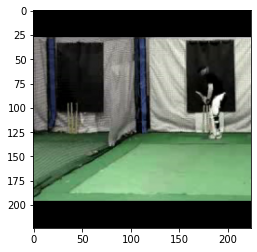

In [17]:
plt.imshow(video[0]/255)

In [18]:
train_df["label"].values.reshape(-1,1)

array([[2],
       [1],
       [2],
       [0],
       [2],
       [0],
       [2],
       [1],
       [2],
       [0],
       [0],
       [0],
       [1],
       [0],
       [2],
       [1],
       [2],
       [0],
       [0],
       [2],
       [1],
       [2],
       [1],
       [2],
       [2],
       [0],
       [2],
       [0],
       [0],
       [2],
       [1],
       [1],
       [2],
       [1],
       [2],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [2],
       [1],
       [2],
       [2],
       [1],
       [1],
       [0],
       [2],
       [2],
       [2],
       [1],
       [0],
       [2],
       [1],
       [0],
       [1],
       [2],
       [2],
       [0],
       [0],
       [1],
       [2],
       [1],
       [2],
       [1],
       [0],
       [1],
       [2],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
    

In [19]:
def prepare_all_videos(video_name , label, root_dir):
    # 비디오 파일 이름의 개수
    num_samples = len(video_name)
    # video_name.values.tolist() : 비디오 파일 이름을 리스트로 변환 해서 리턴
    video_paths = video_name.values.tolist()
    # 비디오 종류를 리턴
    labels = label.values
    # 비디오 종류를 2차원 배열로 변환
    labels = labels.reshape(-1,1)
    # 0으로 초기화된 [비디오 파일개수 * 20 , 224 , 224, 3] 배열 생성
    x = np.zeros(shape=(num_samples*MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3 ), dtype="float32" )
    # 0으로 초기화된 [비디오파일개수 * 20] 인 배열 생성
    y = np.zeros(shape=(num_samples*MAX_SEQ_LENGTH), dtype="float32")
    # 인덱스 초기화
    index = 0
    # 비디오 파일의 개수 만큼 반복
    for idx, path in enumerate(video_paths):
        # 비디오 파일을 읽어서 각 프레임의 이미지를 리턴
        frames = load_video(root_dir+ path)
        # 프레임의 개수 만큼 반복
        for i in range(len(frames)):
            # frame의 i번째 이미지를 x에 추가
            x[index] = np.array(frames[i], dtype="float32")
            # 비디오의 종류가 저장된 labels의 idx 번째를 y에 추가
            y[index]= np.array(labels[idx], dtype="float32")
            # index 1 증가
            index += 1 
    
    # 전체 비디오 프레임을 이미지로 변환한 x 
    # to_categorical(y) : 이미지의 종류 y 를 onehot 인코딩 
    return (x,to_categorical(y))

In [21]:
X_train, y_train = prepare_all_videos(train_df["video_name"], train_df["label"] , data_path)

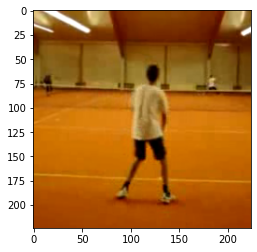

In [22]:
plt.imshow(X_train[0]/255)

In [23]:
conv_base = tf.keras.applications.MobileNetV2(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

14548992/14536120 [==============================] - 0s 0us/step


In [24]:
conv_base.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [25]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Dense(3, activation="softmax"))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1000)              3538984   
_________________________________________________________________
dense (Dense)                (None, 3)                 3003      
Total params: 3,541,987
Trainable params: 3,507,875
Non-trainable params: 34,112
_________________________________________________________________


In [27]:
from tensorflow.keras.optimizers import Adam

In [28]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [29]:
# 이미지를 증강하는 ImageGenerator 객체 생성
train_datagen = ImageDataGenerator(
	rotation_range=30, # 이미지 회전 각도
	zoom_range=0.15, # 이미지 확대 비율
	width_shift_range=0.2, # 이미지 가로 이동 비율
	height_shift_range=0.2, # 이미지 세로 이동 비율
	shear_range=0.15, # 이미지 기울기 비율
	horizontal_flip=True,# 이미지 좌우 반전
	fill_mode="nearest", # 이미지를 회전 이동시 빈공간을 채우는 방식
    rescale=1/255 # 이미지에 1/255 를 곱해줌
	)

In [30]:
# 이미지 학습
model.fit(
	train_datagen.flow(X_train, y_train, batch_size = 32),
	steps_per_epoch=len(X_train) // 32,
	epochs = 3 )

Epoch 1/3
222/222 [==============================] - 1319s 6s/step - loss: 0.6785 - acc: 0.8290
Epoch 2/3
222/222 [==============================] - 1356s 6s/step - loss: 0.6633 - acc: 0.9901
Epoch 3/3
222/222 [==============================] - 1308s 6s/step - loss: 0.6592 - acc: 0.9977


In [ ]:
model.fit(
	train_datagen.flow(X_train, y_train, batch_size = 32),
	steps_per_epoch=len(X_train) // 32,
	epochs = 5 )

Epoch 1/5
222/222 [==============================] - 1400s 6s/step - loss: 0.6562 - acc: 0.9987
Epoch 2/5
222/222 [==============================] - 1449s 7s/step - loss: 0.6536 - acc: 0.9986
Epoch 3/5
222/222 [==============================] - 1439s 6s/step - loss: 0.6509 - acc: 0.9993
Epoch 4/5
222/222 [==============================] - 1382s 6s/step - loss: 0.6483 - acc: 0.9984
Epoch 5/5
 98/222 [============>.................] - ETA: 12:41 - loss: 0.6465 - acc: 0.9990

In [34]:
model.save("/content/drive/MyDrive/Colab Notebooks/Mobilenet_train.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
